**Spark notebook**

This notebook will only work in a Jupyter session running on `mathmadslinux2p`.

You can start your own Jupyter session on `mathmadslinux2p` and open this notebook in Chrome on the MADS Windows server by

1. Login to the MADS Windows server using https://mathportal.canterbury.ac.nz/.
2. Download or copy this notebook to your home directory.
3. Open powershell and run `ssh mathmadslinux2p`.
4. Run `start_pyspark_notebook` or `/opt/anaconda3/bin/jupyter-notebook --ip 132.181.129.68 --port $((8000 + $((RANDOM % 999))))`.
5. Copy / paste the url provided in the shell window into Chrome on the MADS Windows server.
6. Open the notebook from the Jupyter root directory (which is your home directory).
7. Run `start_spark()` to start a spark session in the notebook.
8. Run `stop_spark()` before closing the notebook or kill your spark application by hand using the link in the Spark UI.

In [1]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

In [2]:
# Run this cell to start a spark session in this notebook

start_spark(executor_instances=4, executor_cores=4, worker_memory=4, master_memory=4)

spark.dynamicAllocation.enabled,false
spark.executor.instances,4
spark.sql.warehouse.dir,file:/users/home/dcp31/assignment_2/spark-warehouse
spark.driver.memory,4g
spark.app.startTime,1717674154432
spark.executor.memory,4g
spark.master,spark://masternode2:7077
spark.app.name,dcp31 (jupyter)
spark.executor.id,driver
spark.ui.port,4576
spark.executor.cores,2


In [3]:
# Write your imports and code here or insert cells below

from pyspark.sql import Row, DataFrame, Window, functions as F
from pyspark.sql.types import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import RankingEvaluator
from pyspark.ml.recommendation import ALS

In [4]:
# Determine ideal number of partitions

conf = sc.getConf()

N = int(conf.get("spark.executor.instances"))
M = int(conf.get("spark.executor.cores"))
partitions = 4 * N * M # factor of 4 for smaller partitions for less risk of idle time. But Spark may decide something else. But 8 partitions over 8 cores should run OK

print(f'ideal # partitions = {partitions}')

ideal # partitions = 32


### Question 1 (a)

In [5]:
folder_path = 'hdfs:////data/msd/tasteprofile/triplets.tsv/'

triplets_schema = StructType([
    StructField("user_id", StringType(), True),
    StructField("song_id", StringType(), True),
    StructField("play_count", IntegerType(), True)
])

triplets = (spark.read.option("header", "false") 
                .option("delimiter", "\t") 
                .schema(triplets_schema)
                .csv(folder_path + '*.gz')                
                .repartition(32)
                .cache()
                )
 
triplets.printSchema()

show_as_html(triplets)

root
 |-- user_id: string (nullable = true)
 |-- song_id: string (nullable = true)
 |-- play_count: integer (nullable = true)



,user_id,song_id,play_count
0,ae4d21862db75b3cdbd9b400bbba647fc7e32a18,SOOCMIB12A8C13E465,5
1,bc2066eda369e411b0a64255874bc38dbb30aa8e,SOOXDVF12A6D4FB4AD,1
2,2bf302479a335436d97c248cb00019d0cceae93b,SOFBOXR12A6310F0FC,3
3,ba30b82fb562ac0ea0f4afaba54329d4af751af3,SOPIBLV12A8C136C2A,6
4,80779cf1be0cf7ea2adeaa6b92572a460ab7b853,SOQCIQX12A8C13B272,2
5,5a502c3f2ce754b883f75ca83617ebd2120bb255,SOJMITH12A8C13B6E5,1
6,7c9dfcfbf7427c52d8d63a394389155f8ed94708,SOUEGBF12AB017EFD5,1
7,7df8f300923df6260c4d74eb6cf84ccfee37646a,SOSXJHF12AB0181A1B,1
8,8efaa70c0ffb38fce3c3327d071fe70a97188290,SOFQTHB12A8C1447C9,6
9,0d8ad6dc1fc6b2a0d6fe1bc916f07b1a0ec98e09,SOSBMZB12A6D4FB47A,1


In [6]:
# count rows

row_count = triplets.count()
print(row_count)

48373586


### Question 1 (b)

In [7]:
# number of unique songs

triplets.select(F.col("song_id")).distinct().count()

384546

In [8]:
# number of unique users

triplets.select(F.col("user_id")).distinct().count()

1019318

In [9]:
# total number of song plays across all users (for interest and quality check)

total_plays = triplets.select(F.col("play_count")).agg(F.sum("play_count"))
show_as_html(total_plays)

,sum(play_count)
0,138680243


### Question 1 (c)

In [7]:
# how many songs has the most active user played?

# group by user, sum number of plays to find who has been most active, count the number of unique songs, order by 
# total_play_count to list most active user at top of df

user_agg = (
    triplets.groupBy("user_id") 
    .agg(F.sum("play_count").alias("total_play_count"),
         F.countDistinct("song_id").alias("unique_songs"))
    .orderBy(F.col("total_play_count").desc())
)

# the most active user has listened to 202 different songs
show_as_html(user_agg)

,user_id,total_play_count,unique_songs
0,093cb74eb3c517c5179ae24caf0ebec51b24d2a2,13132,202
1,119b7c88d58d0c6eb051365c103da5caf817bea6,9884,1451
2,3fa44653315697f42410a30cb766a4eb102080bb,8210,151
3,a2679496cd0af9779a92a13ff7c6af5c81ea8c7b,7015,557
4,d7d2d888ae04d16e994d6964214a1de81392ee04,6494,1319
5,4ae01afa8f2430ea0704d502bc7b57fb52164882,6472,478
6,b7c24f770be6b802805ac0e2106624a517643c17,6150,1446
7,113255a012b2affeab62607563d03fbdf31b08e7,5656,1155
8,6d625c6557df84b60d90426c0116138b617b9449,5620,1398
9,99ac3d883681e21ea68071019dba828ce76fe94d,5602,987


In [12]:
# double check max play count

user_agg.select(F.max(F.col("total_play_count"))).show()

+---------------------+
|max(total_play_count)|
+---------------------+
|                13132|
+---------------------+



In [13]:
# identify most unique songs

user_agg.select(F.max(F.col("unique_songs"))).show()

+-----------------+
|max(unique_songs)|
+-----------------+
|             4400|
+-----------------+



In [29]:
# descriptive stats for user play count

desc_stats = user_agg.select(F.col("total_play_count")).describe()

show_as_html(desc_stats)

,summary,total_play_count
0,count,1019318
1,mean,136.0519906447252
2,stddev,184.52548802802545
3,min,10
4,max,13132


In [33]:
#user_agg.agg(F.median(F.col("total_play_count"))).show() # not available?

# compute median manually
median = user_agg.approxQuantile("total_play_count", [0.5], 0.01)[0]
print("Median:", median)

Median: 71.0


In [30]:
# compute descriptive statistics for user unique songs

desc_stats = user_agg.select(F.col("unique_songs")).describe()

show_as_html(desc_stats)

,summary,unique_songs
0,count,1019318
1,mean,47.45681524313316
2,stddev,57.81573063001338
3,min,10
4,max,4400


In [35]:
# manually compute median 

median = user_agg.approxQuantile("unique_songs", [0.5], 0.01)[0]
print("Median:", median)

Median: 27.0


In [12]:
# checking it matches original count

count = user_agg.agg(F.sum("total_play_count"))
show_as_html(count)

,sum(total_play_count)
0,138680243


### Question 1(d)

In [8]:
# visualise user plays per song, group by song_id, sum number plays per song, order with largest play count at top

song_agg = (
    triplets.groupBy("song_id") 
    .agg(F.sum("play_count").alias("total_play_count"))
    .orderBy(F.col("total_play_count").desc())
)

show_as_html(song_agg)

,song_id,total_play_count
0,SOBONKR12A58A7A7E0,726885
1,SOAUWYT12A81C206F1,648239
2,SOSXLTC12AF72A7F54,527893
3,SOFRQTD12A81C233C0,425463
4,SOEGIYH12A6D4FC0E3,389880
5,SOAXGDH12A8C13F8A1,356533
6,SONYKOW12AB01849C9,292642
7,SOPUCYA12A8C13A694,274627
8,SOUFTBI12AB0183F65,268353
9,SOVDSJC12A58A7A271,244730


In [37]:
# decriptive stats for song plays 

desc_stats = song_agg.select(F.col("total_play_count")).describe()

show_as_html(desc_stats)

,summary,total_play_count
0,count,384546
1,mean,360.63369011769726
2,stddev,3256.809395023507
3,min,1
4,max,726885


In [38]:
# manually calculate median 

median = song_agg.approxQuantile("total_play_count", [0.5], 0.01)[0]
print("Median:", median)

Median: 31.0


In [15]:
# double check

row_count = song_agg.count()
print(row_count) # matches number of unique songs

384546


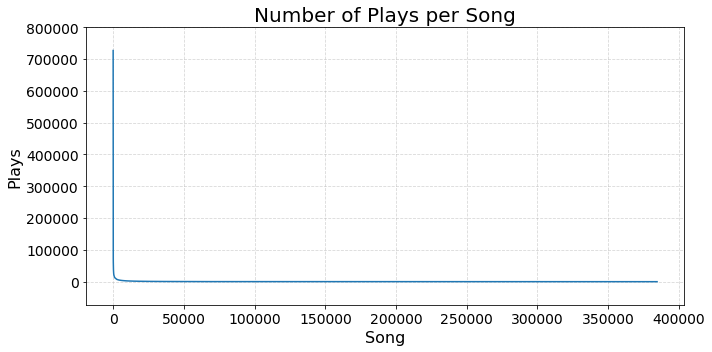

In [19]:
# visualise distribution of number of plays per song

song_agg_pd = song_agg.toPandas()

x = range(len(song_agg_pd))
y = song_agg_pd["total_play_count"]

plt.close('all')

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x, y)

ax.grid(alpha=0.5, linestyle='--')

ax.margins(0.05, 0.1)

ax.set_title("Number of Plays per Song", fontsize=20)
ax.set_xlabel('Song', fontsize=16)
ax.set_ylabel('Plays', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)

fig.tight_layout()

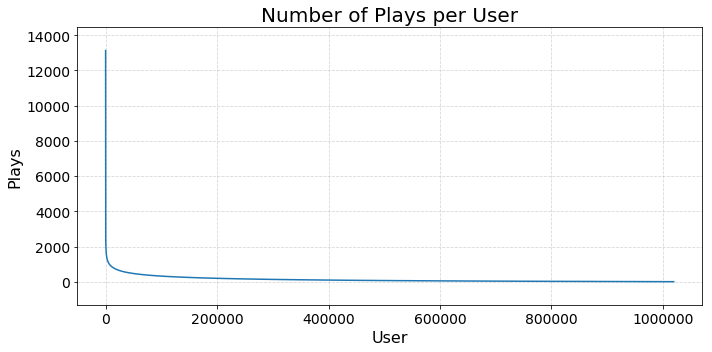

In [20]:
# visualise song plays per user 

user_agg_pd = user_agg.toPandas()

x = range(len(user_agg_pd))
y = user_agg_pd["total_play_count"]

plt.close('all')

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x, y)

ax.grid(alpha=0.5, linestyle='--')

ax.margins(0.05, 0.1)

ax.set_title("Number of Plays per User", fontsize=20)
ax.set_xlabel('User', fontsize=16)
ax.set_ylabel('Plays', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)

fig.tight_layout()

In [15]:
# visualise number of unique songs per user.First removing total play count and ordering by descending...

user_agg_songs = user_agg.orderBy(F.col("unique_songs").desc()).drop("total_play_count")
show_as_html(user_agg_songs)

,user_id,unique_songs
0,ec6dfcf19485cb011e0b22637075037aae34cf26,4400
1,8cb51abc6bf8ea29341cb070fe1e1af5e4c3ffcc,1651
2,fef771ab021c200187a419f5e55311390f850a50,1614
3,5a3417a1955d9136413e0d293cd36497f5e00238,1604
4,c1255748c06ee3f6440c51c439446886c7807095,1566
5,4e73d9e058d2b1f2dba9c1fe4a8f416f9f58364f,1544
6,cbc7bddbe3b2f59fdbe031b3c8d0db4175d361e6,1536
7,96f7b4f800cafef33eae71a6bc44f7139f63cd7a,1491
8,119b7c88d58d0c6eb051365c103da5caf817bea6,1451
9,b7c24f770be6b802805ac0e2106624a517643c17,1446


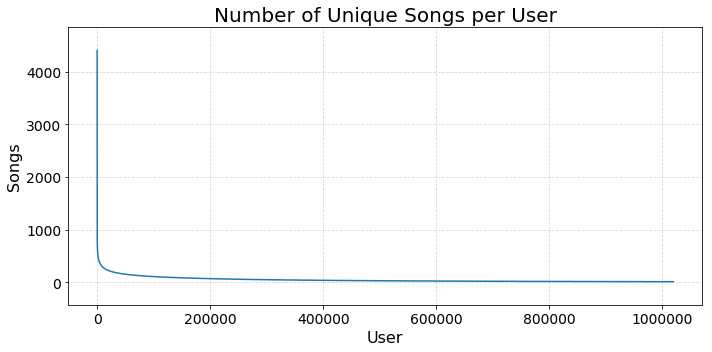

In [16]:
# visualise number of unique songs per user 

user_agg_songs_pd = user_agg_songs.toPandas()

x = range(len(user_agg_songs_pd))
y = user_agg_songs_pd["unique_songs"]

plt.close('all')

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x, y)

ax.grid(alpha=0.5, linestyle='--')

ax.margins(0.05, 0.1)

ax.set_title("Number of Unique Songs per User", fontsize=20)
ax.set_xlabel('User', fontsize=16)
ax.set_ylabel('Songs', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)

fig.tight_layout()

### Question 2(a)

In [11]:
# clean dataframe

N = 8 # minimum play count for a song. This leaves 76% of the unique songs. Tried various numbers.

# filter for total play ocunt 8 or above and then drop that col
cleaned_songs = song_agg.filter(F.col("total_play_count") >= N).drop("total_play_count")
row_count = cleaned_songs.count()
print(row_count)
show_as_html(cleaned_songs, 5)

292901


,song_id
0,SOBONKR12A58A7A7E0
1,SOAUWYT12A81C206F1
2,SOSXLTC12AF72A7F54
3,SOFRQTD12A81C233C0
4,SOEGIYH12A6D4FC0E3


In [18]:
# after consideration, it was decided to set M at 10. Therefore, this does not reduce the dataset as this appears to be the 
# minimum num of unique songs to be included in the triplets dataset. All users in the dataset will be included, as they've 
# listened to 10 different songs, so enough to start making recommendations on. The relevant code has been commented out due 
# to this decision

# M = 10 

# cleaned_users = user_agg_songs.filter(F.col("unique_songs") >= M).drop("unique_songs")
# row_count = cleaned_users.count()
# print(row_count)
# show_as_html(cleaned_users, 5)

1019318


,user_id
0,ec6dfcf19485cb011e0b22637075037aae34cf26
1,8cb51abc6bf8ea29341cb070fe1e1af5e4c3ffcc
2,fef771ab021c200187a419f5e55311390f850a50
3,5a3417a1955d9136413e0d293cd36497f5e00238
4,c1255748c06ee3f6440c51c439446886c7807095


In [12]:
# broadcast smaller cleaned_songs df to workers. Inner join with triplets on song_id to filter for songs that have been listened 
# to 8 or more times. 

cleaned_df = triplets.join(F.broadcast(cleaned_songs), on = "song_id", how="inner")
row_count = cleaned_df.count()
print(row_count)
cleaned_df.show(5)

48148495
+------------------+--------------------+----------+
|           song_id|             user_id|play_count|
+------------------+--------------------+----------+
|SOOCMIB12A8C13E465|ae4d21862db75b3cd...|         5|
|SOOXDVF12A6D4FB4AD|bc2066eda369e411b...|         1|
|SOFBOXR12A6310F0FC|2bf302479a335436d...|         3|
|SOPIBLV12A8C136C2A|ba30b82fb562ac0ea...|         6|
|SOQCIQX12A8C13B272|80779cf1be0cf7ea2...|         2|
+------------------+--------------------+----------+
only showing top 5 rows



In [20]:
# commented out due to decision to keep all users in the dataset

# cleaned_df_2 = cleaned_df.join(F.broadcast(cleaned_users), on = "user_id", how="inner")
# cleaned_df_2.cache()
# row_count = cleaned_df_2.count()
# print(row_count)
# show_as_html(cleaned_df_2, 5)

47887216


,user_id,song_id,play_count
0,38019d68a5aed23a9da5b2a3431bfb69482fa9a1,SOFXJCS12A58A7DF02,2
1,859b7280c1afc08b48a3adf39096066fbfee57f2,SOGHFDV12A6D4F7E0D,1
2,33aedbf962b63e6e07839b7a6ef19530e0eefa42,SOLZYFN12AF729F78B,1
3,25f8245b190212c9ea6b823f15ae5d03de42dc2c,SOSVQNK12AC468D6BE,1
4,7f771f21564d764766428d2954900d8bd71e71c1,SOCGPMQ12AF72A21A8,1


In [13]:
# sanity check - there are users with less unique listens than the threshold (10) likely because the other songs have been removed 
# from the df as they haven't been played more than 8 times.

users = (
    cleaned_df.groupBy("user_id") 
    .agg(F.countDistinct("song_id").alias("unique_songs"))
    .orderBy(F.col("unique_songs").asc())
)
show_as_html(users)

,user_id,unique_songs
0,72c58259f808b6a935bee0023d7edbfd94ba69e1,1
1,cbe4ded7ff0160379c48c024c3371eb9fd5978a4,1
2,3bfa6b12e69f4baa4c4b086d54ef6edf1edf5f51,2
3,78fff8c27b99736cc75fdda44e385019e60bbca3,2
4,299658b5428e7f52239b7965659075c6177fc7a6,2
5,2eeb254f35082722d187582b32e251bebfcf1143,2
6,6d7f1169dc24d4e5e9513a41d02f7e2d689d15a5,2
7,358f334bbf56b645f74fff8c254924aea227c4c5,3
8,fe9158390352f23cea654017f226bbf74490bb77,3
9,9cbd15c1f7f06033a46339f80a3f5173833af10e,3


In [14]:
# sanity check 
songs = (
    cleaned_df.groupBy("song_id") 
    .agg(F.sum("play_count").alias("total_play_count"))
    .orderBy(F.col("total_play_count").asc())
)
show_as_html(songs)

,song_id,total_play_count
0,SOHMROM12A6D4F74EC,8
1,SOJNYYV12AF72ACBCA,8
2,SOJKWWN12AB01806F1,8
3,SOWIMIV12AC3DF6DC0,8
4,SOTMCXW12AB0187874,8
5,SOPOOBN12AB0183F2A,8
6,SOQIJYN12AB018399F,8
7,SOMOLSI12AAF3B5B6D,8
8,SOORVEQ12A8C13CDD5,8
9,SOCGNIZ12A6D4FDD63,8


### Question 2(b)

In [15]:
# calculate total play count for new cleaned_df

total_plays_df = cleaned_df.agg(F.sum(F.col("play_count")).alias("total_play_count"))

total_plays = total_plays_df.collect()[0]["total_play_count"]

print(total_plays)
print(total_plays * 0.25)

# the test set needs to include at least 25% of the total plays so 34,592,792 plays

138371167
34592791.75


In [22]:
# create training and test sets using randomsplit
training, test = cleaned_df.randomSplit([0.75, 0.25], seed=40) 

training.cache()
test.cache()

print(training.count())
print(test.count())

36110682
12037813


In [17]:
# check number of plays per set 

total_plays_df = training.agg(F.sum(F.col("play_count")).alias("total_play_count"))
total_plays = total_plays_df.collect()[0]["total_play_count"]
print(total_plays) # 75%

total_plays_df = test.agg(F.sum(F.col("play_count")).alias("total_play_count"))
total_plays = total_plays_df.collect()[0]["total_play_count"]
print(total_plays) # 25%

103769349
34601818


In [18]:
# check if there are any users in test who are not in training

missing_users = test.join(training, on="user_id", how="leftanti")
show_as_html(missing_users)

# all user_ids are matched between training and test

,user_id,song_id,play_count


In [63]:
# not needed as no missing users but there were originally, hence this code was written

# test = test.join(missing_users, on="user_id", how="leftanti")
# test.count()

11974714

In [64]:
# not needed as no missing users 

# # recheck
# missing_users = test.join(training, on="user_id", how="leftanti")
# show_as_html(missing_users)

,user_id,song_id,play_count


In [65]:
# not needed as no missing users 

# total_plays_df = training.agg(F.sum(F.col("play_count")).alias("total_play_count"))
# total_plays = total_plays_df.collect()[0]["total_play_count"]
# print(total_plays) # still 75%

# total_plays_df = test.agg(F.sum(F.col("play_count")).alias("total_play_count"))
# total_plays = total_plays_df.collect()[0]["total_play_count"]
# print(total_plays) # still 25%

103393378
34510301


### Question 2(c)

In [23]:
# prepare data for ALS model
# variables need to be numeric 

# convert string user_id to a numeric id, user_index
user_indexer = StringIndexer(inputCol="user_id", outputCol="user_index", handleInvalid="skip")
userIndexerModel = user_indexer.fit(training)

training = userIndexerModel.transform(training)
test = userIndexerModel.transform(test)

In [24]:
# convert string song_id to a numeric id, song_index

song_indexer = StringIndexer(inputCol="song_id", outputCol="song_index", handleInvalid="skip")
songIndexerModel = song_indexer.fit(training)

training = songIndexerModel.transform(training)
test = songIndexerModel.transform(test)

In [25]:
# checking data types appropriate 

training.printSchema()
test.printSchema()

training.cache()
test.cache()

training.show(5)
test.show(5)

root
 |-- song_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- play_count: integer (nullable = true)
 |-- user_index: double (nullable = false)
 |-- song_index: double (nullable = false)

root
 |-- song_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- play_count: integer (nullable = true)
 |-- user_index: double (nullable = false)
 |-- song_index: double (nullable = false)

+------------------+--------------------+----------+----------+----------+
|           song_id|             user_id|play_count|user_index|song_index|
+------------------+--------------------+----------+----------+----------+
|SOAAADD12AB018A9DD|8cf21d682f872dbe9...|         3|   96749.0|  242907.0|
|SOAAAFI12A6D4F9C66|762ab9285d2200258...|         1|     426.0|   93753.0|
|SOAAAFI12A6D4F9C66|cacc614aaaf8b52b7...|         1|  626934.0|   93753.0|
|SOAAAGK12AB0189572|01af5e2e5171efb50...|         1|  302479.0|   93754.0|
|SOAAAGK12AB0189572|2b5d5df8aad989370...|        

In [26]:
# train ALS model

als = ALS(maxIter=5, 
          regParam=0.01, 
          userCol="user_index", 
          itemCol="song_index", 
          ratingCol="play_count", 
          implicitPrefs=True, 
          seed = 40)

alsModel = als.fit(training)

In [27]:
# predict relevance scores

pred = alsModel.transform(test)
pred.cache()

pred.printSchema()

pred.show()

root
 |-- song_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- play_count: integer (nullable = true)
 |-- user_index: double (nullable = false)
 |-- song_index: double (nullable = false)
 |-- prediction: float (nullable = false)

+------------------+--------------------+----------+----------+----------+----------+
|           song_id|             user_id|play_count|user_index|song_index|prediction|
+------------------+--------------------+----------+----------+----------+----------+
|SOUVTSM12AC468F6A7|1ad1f96dbc79481a0...|         1|     573.0|      12.0|0.51137924|
|SOUVTSM12AC468F6A7|13a2d690b099bcd3f...|        12|     609.0|      12.0| 0.7306137|
|SOUVTSM12AC468F6A7|8f39128a109151373...|         2|    1076.0|      12.0|0.46392044|
|SOUVTSM12AC468F6A7|7abf66fd49edf76e3...|        12|    3849.0|      12.0|  0.974484|
|SOUVTSM12AC468F6A7|32d22b45bfdc0e771...|         1|    4751.0|      12.0| 0.5033116|
|SOUVTSM12AC468F6A7|e1a14ab9ad41a7cfb...|         1|    6

In [28]:
# generate 5 song recommendations for users in test set
k = 5

recommendations = alsModel.recommendForUserSubset(test, k)
recommendations.cache()

recommendations.printSchema()
recommendations.show()

root
 |-- user_index: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- song_index: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)

+----------+--------------------+
|user_index|     recommendations|
+----------+--------------------+
|        12|[{30, 0.37014893}...|
|        18|[{82, 0.4247712},...|
|        38|[{1, 0.61031765},...|
|        70|[{9, 0.20816997},...|
|        93|[{34, 0.48767397}...|
|       190|[{0, 0.23347941},...|
|       218|[{16, 0.5683569},...|
|       273|[{30, 0.4888745},...|
|       300|[{1, 0.7161213}, ...|
|       340|[{1, 0.30070737},...|
|       343|[{1, 0.5952237}, ...|
|       412|[{14, 0.6218483},...|
|       434|[{1, 0.9353242}, ...|
|       475|[{1, 0.4927749}, ...|
|       536|[{0, 0.65407133},...|
|       585|[{1, 1.0984986}, ...|
|       600|[{1, 0.9879303}, ...|
|       611|[{1, 0.4381372}, ...|
|       615|[{58, 0.46659923}...|
|       

In [29]:
# from MovieLensImplicitFeedback notebook
# Collect and sort relevant items in order of descending relevance (e.g. play_count)

relevant = (
    test
    .groupBy("user_index")
    .agg(
        F.reverse(F.sort_array(F.collect_list(
            F.struct(
                F.col("play_count"),
                F.col("song_index"),
            )
        ))).alias("relevant")
    )
)

relevant.cache()
relevant.printSchema()
relevant.show()

root
 |-- user_index: double (nullable = false)
 |-- relevant: array (nullable = false)
 |    |-- element: struct (containsNull = false)
 |    |    |-- play_count: integer (nullable = true)
 |    |    |-- song_index: double (nullable = false)

+----------+--------------------+
|user_index|            relevant|
+----------+--------------------+
|       6.0|[{9, 4962.0}, {9,...|
|      13.0|[{5, 286638.0}, {...|
|      99.0|[{10, 31184.0}, {...|
|     106.0|[{23, 279.0}, {16...|
|     122.0|[{23, 12519.0}, {...|
|     194.0|[{7, 9561.0}, {5,...|
|     196.0|[{21, 2038.0}, {2...|
|     209.0|[{72, 1649.0}, {3...|
|     215.0|[{10, 14736.0}, {...|
|     350.0|[{10, 269.0}, {9,...|
|     355.0|[{32, 766.0}, {25...|
|     364.0|[{21, 889.0}, {18...|
|     365.0|[{6, 1542.0}, {5,...|
|     369.0|[{72, 23106.0}, {...|
|     411.0|[{10, 2849.0}, {6...|
|     480.0|[{6, 566.0}, {5, ...|
|     485.0|[{20, 30821.0}, {...|
|     490.0|[{26, 15.0}, {20,...|
|     496.0|[{11, 5228.0}, {1...|
|     49

In [30]:
# from MovieLensImplicitFeedback notebook
# Merge recommendations and relevant items so they can be compared

temp = (
    recommendations
    .select(
        F.col("user_index"),
        F.col("recommendations.song_index").alias("recommendations").astype(ArrayType(DoubleType())),
    )
    .join(
        relevant
        .select(
            F.col("user_index"),
            F.col("relevant.song_index").alias("relevant").astype(ArrayType(DoubleType())),
        ),
        on="user_index",
        how="inner"
    )
)
temp.cache()

temp.printSchema()
temp.show()

root
 |-- user_index: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- relevant: array (nullable = false)
 |    |-- element: double (containsNull = true)

+----------+--------------------+--------------------+
|user_index|     recommendations|            relevant|
+----------+--------------------+--------------------+
|         6|[1.0, 64.0, 58.0,...|[4962.0, 27.0, 33...|
|        13|[6.0, 34.0, 4.0, ...|[286638.0, 203575...|
|        99|[30.0, 1.0, 25.0,...|[31184.0, 6538.0,...|
|       106|[112.0, 0.0, 1.0,...|[279.0, 250.0, 47...|
|       122|[1.0, 58.0, 64.0,...|[12519.0, 105.0, ...|
|       194|[0.0, 1.0, 8.0, 7...|[9561.0, 121420.0...|
|       196|[6.0, 99.0, 15.0,...|[2038.0, 7441.0, ...|
|       209|[30.0, 25.0, 1.0,...|[1649.0, 172470.0...|
|       215|[25.0, 16.0, 17.0...|[14736.0, 1556.0,...|
|       350|[34.0, 58.0, 1.0,...|[269.0, 10162.0, ...|
|       355|[1.0, 58.0, 64.0,...|[766.0, 7630.0, 3...

### Question 2(d)

In [31]:
# check a few random users for a qualitative assessment of recommendations

qc_check = temp.filter(F.col("user_index").isin(99, 355, 497))
qc_check.cache()
show_as_html(qc_check)

,user_index,recommendations,relevant
0,99,"[30.0, 1.0, 25.0, 16.0, 17.0]","[31184.0, 6538.0, 6382.0, 5844.0, 274918.0, 86..."
1,355,"[1.0, 58.0, 64.0, 112.0, 14.0]","[766.0, 7630.0, 333.0, 1.0, 15036.0, 6051.0, 7..."
2,497,"[34.0, 112.0, 64.0, 0.0, 93.0]","[5800.0, 3075.0, 2060.0, 91903.0, 10323.0, 852..."


In [33]:
# need to make the dataframe long

# explode the arrays
qc_rec = (
    qc_check.select(F.col("user_index"), F.posexplode("recommendations")
                    .alias("pos", "recommendation")
                   )
)

qc_rel = (
    qc_check.select(F.col("user_index"), F.posexplode("relevant")
                    .alias("pos", "relevant")
                   )
)

# join the exploded dataframes
qc_check_long = (
    qc_rec.join(qc_rel, ["user_index", "pos"])
    .select("user_index", "recommendation", "relevant")
    .orderBy("user_index")
)

qc_check_long.show()

+----------+--------------+--------+
|user_index|recommendation|relevant|
+----------+--------------+--------+
|        99|          16.0|  5844.0|
|        99|           1.0|  6538.0|
|        99|          17.0|274918.0|
|        99|          25.0|  6382.0|
|        99|          30.0| 31184.0|
|       355|           1.0|   766.0|
|       355|         112.0|     1.0|
|       355|          64.0|   333.0|
|       355|          14.0| 15036.0|
|       355|          58.0|  7630.0|
|       497|          34.0|  5800.0|
|       497|         112.0|  3075.0|
|       497|          64.0|  2060.0|
|       497|           0.0| 91903.0|
|       497|          93.0| 10323.0|
+----------+--------------+--------+



In [34]:
# create df of just song index and ids
songs = test.select("song_id", "song_index").distinct()

In [35]:
# broadcast smaller df to workers. Inner join with songs to obtain song_id. Drop index and rec cols and rename song_id as rec
qc_check_users = (
    songs.join(F.broadcast(qc_check_long), songs.song_index == qc_check_long.recommendation, how="inner")
    .drop("song_index", "recommendation")
    .withColumnRenamed("song_id", "recommendation")
)

show_as_html(qc_check_users)

,recommendation,user_index,relevant
0,SOCVTLJ12A6310F0FD,99,274918.0
1,SOPUCYA12A8C13A694,355,15036.0
2,SOVDLZN12AB0185BEA,497,2060.0
3,SOVDLZN12AB0185BEA,355,333.0
4,SOKLRPJ12A8C13C3FE,99,5844.0
5,SOMGIYR12AB0187973,497,3075.0
6,SOMGIYR12AB0187973,355,1.0
7,SOPQLBY12A6310E992,99,31184.0
8,SOFRQTD12A81C233C0,497,91903.0
9,SOPXKYD12A6D4FA876,99,6382.0


In [36]:
# repeat above for recommended songs

qc_check_users_2 = (
    songs.join(F.broadcast(qc_check_users), songs.song_index == qc_check_long.relevant, how="inner")
    .drop("song_index", "relevant")
    .withColumnRenamed("song_id", "relevant")
)

qc_check_users_2.cache()

show_as_html(qc_check_users_2)

,relevant,recommendation,user_index
0,SOXFAIJ12AB018009B,SOAXGDH12A8C13F8A1,99
1,SOEHHJG12A6D4F968A,SOAXGDH12A8C13F8A1,355
2,SOMUPMX12A8C13BD0D,SOPUCYA12A8C13A694,355
3,SOITXSQ12A8C1391BF,SOCVTLJ12A6310F0FD,99
4,SOWCNDE12A6D4F7D25,SOTCMDJ12A6D4F8528,497
5,SOFRBTA12A58A7853E,SOEPZQS12A8C1436C7,497
6,SOHQFNK12A6701C0B9,SOVDLZN12AB0185BEA,355
7,SOZHBRQ12A6D4F7D2E,SOMGIYR12AB0187973,497
8,SOMAGFF12A6D4F7231,SOTVLQY12A58A798C2,355
9,SOYHTAT12A81C23955,SOVDLZN12AB0185BEA,497


In [37]:
# create df for relevant items, creating type col to identify relevant from recommended songs
df_relevant = qc_check_users_2.select(
    F.col("user_index"),
    F.col("relevant").alias("song_id"),
    F.lit("relevant").alias("type")
)

# same for recommendations
df_recommendation = qc_check_users_2.select(
    F.col("user_index"),
    F.col("recommendation").alias("song_id"),
    F.lit("recommendation").alias("type")
)

# stack
qc_long = df_relevant.union(df_recommendation)

qc_long.cache()

show_as_html(qc_long)

,user_index,song_id,type
0,99,SOXFAIJ12AB018009B,relevant
1,355,SOEHHJG12A6D4F968A,relevant
2,355,SOMUPMX12A8C13BD0D,relevant
3,99,SOITXSQ12A8C1391BF,relevant
4,497,SOWCNDE12A6D4F7D25,relevant
5,497,SOFRBTA12A58A7853E,relevant
6,355,SOHQFNK12A6701C0B9,relevant
7,497,SOZHBRQ12A6D4F7D2E,relevant
8,355,SOMAGFF12A6D4F7231,relevant
9,497,SOYHTAT12A81C23955,relevant


In [38]:
# load metadata to find out song title, artist, etc

folder_path = ("hdfs:////data/msd/main/summary/metadata.csv.gz")

metadata = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "true")
    .option("inferSchema", "true")
    .load(folder_path)
)

metadata.cache()

show_as_html(metadata, 5)

,analyzer_version,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_location,artist_longitude,artist_mbid,artist_name,artist_playmeid,genre,idx_artist_terms,idx_similar_artists,release,release_7digitalid,song_hotttnesss,song_id,title,track_7digitalid
0,None,4069,0.649822,0.394032,ARYZTJS1187B98C555,NaN,None,None,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,44895,None,0,0,Monster Ballads X-Mas,633681,0.5428987432910862,SOQMMHC12AB0180CB8,Silent Night,7032331
1,None,113480,0.439604,0.356992,ARMVN3U1187FB3A1EB,NaN,None,None,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,-1,None,0,0,Karkuteillä,145266,0.2998774882739778,SOVFVAK12A8C1350D9,Tanssi vaan,1514808
2,None,63531,0.643681,0.437504,ARGEKB01187FB50750,55.8578,"Glasgow, Scotland",-4.24251,3d403d44-36ce-465c-ad43-ae877e65adc4,Hudson Mohawke,-1,None,0,0,Butter,625706,0.6178709693948196,SOGTUKN12AB017F4F1,No One Could Ever,6945353
3,None,65051,0.448501,0.372349,ARNWYLR1187B9B2F9C,NaN,None,None,12be7648-7094-495f-90e6-df4189d68615,Yerba Brava,34000,None,0,0,De Culo,199368,None,SOBNYVR12A8C13558C,Si Vos Querés,2168257
4,None,158279,0.000000,0.000000,AREQDTE1269FB37231,NaN,None,None,None,Der Mystic,-1,None,0,0,Rene Ablaze Presents Winter Sessions,209038,None,SOHSBXH12A8C13B0DF,Tangle Of Aspens,2264873


In [39]:
# get the cols we need to the df is smaller for join 

qc_metadata = metadata.select("artist_name", "song_id", "title") # originally included genre, but empty so removed
qc_metadata.cache()

DataFrame[artist_name: string, song_id: string, title: string]

In [40]:
# broadcast smaller df to workers and join to metadata

qc_data = qc_metadata.join(F.broadcast(qc_long), on="song_id", how="inner")
show_as_html(qc_data, 30)

,song_id,artist_name,title,user_index,type
0,SOFRBTA12A58A7853E,Television,Ain't That Nothin' (Remastered LP Version),497,relevant
1,SOMAGFF12A6D4F7231,Regina Spektor,On The Radio (Album Version),355,relevant
2,SOMGIYR12AB0187973,Panic At The Disco,Behind The Sea [Live In Chicago],355,recommendation
3,SOMGIYR12AB0187973,Panic At The Disco,Behind The Sea [Live In Chicago],497,recommendation
4,SOAXGDH12A8C13F8A1,Florence + The Machine,Dog Days Are Over (Radio Edit),355,recommendation
5,SOAXGDH12A8C13F8A1,Florence + The Machine,Dog Days Are Over (Radio Edit),99,recommendation
6,SOAXGDH12A8C13F8A1,Florence + The Machine,Dog Days Are Over (Radio Edit),355,relevant
7,SOITXSQ12A8C1391BF,The Psychedelic Furs,Torch,99,relevant
8,SOPUCYA12A8C13A694,Five Iron Frenzy,Canada,355,recommendation
9,SONKCZI12AF72A35C1,Wang Chung,Praying To A New God,497,relevant


In [41]:
# write to outputs

(
    qc_data
    .repartition(1)
    .write
    .format("com.databricks.spark.csv")
    .option("header", "true")
    .mode("overwrite")
    .save("/user/dcp31/assignment_2/qual_check.csv")
)

In [42]:
# make accessible

!hdfs dfs -get /user/dcp31/assignment_2/qual_check.csv /users/home/dcp31/assignment_2/

### Question 2(e)

In [43]:
# from MovieLensImplicitFeedback notebook
# Metrics

from pyspark.ml.evaluation import RankingEvaluator

k = 10

evaluator = RankingEvaluator(predictionCol="recommendations", labelCol="relevant")

precisionAtK = evaluator.evaluate(temp, {evaluator.metricName: "precisionAtK",            evaluator.k: k})
mapAtK       = evaluator.evaluate(temp, {evaluator.metricName: "meanAveragePrecisionAtK", evaluator.k: k})
ndcgAtK      = evaluator.evaluate(temp, {evaluator.metricName: "ndcgAtK",                 evaluator.k: k})

print(f'metrics for implicit feedback')
print(f'')
print(f'precision @ K: {precisionAtK:.5f}')
print(f'MAP @ K:       {mapAtK:.5f}')
print(f'NDCG @ K:      {ndcgAtK:.5f}')
print(f'')

metrics for implicit feedback

precision @ K: 0.01791
MAP @ K:       0.01536
NDCG @ K:      0.03145



### Stop Spark ###

In [44]:
# Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI

stop_spark()